# Face Classification

Our main goal is to be able to make accurate predictions on a face’s age, gender and ethnicity. To achieve this, we will explore ways on how Transfer Learning and splitting the training and testing data among groups affect our results and see if there are any benefits to do so. We will also use multiple models - from basic linear regression to neural networks - to achieve the best accuracy. Our main end goal then is to create a functional user interface for anyone to be able to play around with our model.

[age] is an integer from 0 to 116, indicating the age

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern) respectively.

## Table of content

1. Importing modules
2. Loading Dataset
3. Analyze Distributions
    - Age Distribution
    - Ethnicity Distribution
    - Gender Distribution
    - Inspecting the images
4. Split and Preprocess the data
5. Modelling and Training
    - Decision Trees
    - Random Forests
    - Logistic Regression
    - SVM
    - Neural Networks
6. Evaluating Models
7. Transfer Learning

## 1. Load modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
import sklearn.tree
import plotly.express as px
import time
import pickle
import os.path
from PIL import Image
import base64
import io
import cv2
import tensorflow as tf

pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', 50)

In [2]:
# pip install tensorflow==2.3.0

## 2. Load dataset

In [3]:
df = pd.read_csv('./data/age_gender_race.csv')

df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
print(len(df))
print(len(df.pixels[0]))

23705
8917


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


Defining some metadata that will be useful afterwards.

In [6]:
GENDER_CATEGORIES = ['Male', 'Female']
RACE_CATEGORIES = ['White', 'Black', 'Asian', 'Indian', 'Others']
IMG_SIZE = 48

## 3. Analyzing the data

### 3a. Age Distribution

In [7]:
# fig = px.histogram(df, x="age", marginal="rug", hover_data=df.columns)
# fig.show()

### 3b. Ethnicity Distribution

In [8]:
# fig = px.histogram(df, x="ethnicity",color="ethnicity",hover_data=df.columns)
# fig.show()

### 3c. Gender Distribution

In [9]:
# fig = px.histogram(df, x="gender", color="gender", hover_data=df.columns)
# fig.show()

### 3d. Inspecting the images

In [10]:
X=np.zeros(shape=(23705,2304))

for i in range(len(df.pixels)):
    df.pixels[i]=np.array(df.pixels[i].split(),dtype='float32')
    X[i]=df.pixels[i]
    
X.shape

(23705, 2304)

In [11]:
X_reshaped=X.reshape(-1,IMG_SIZE,IMG_SIZE)

In [12]:
X_reshaped.shape

(23705, 48, 48)

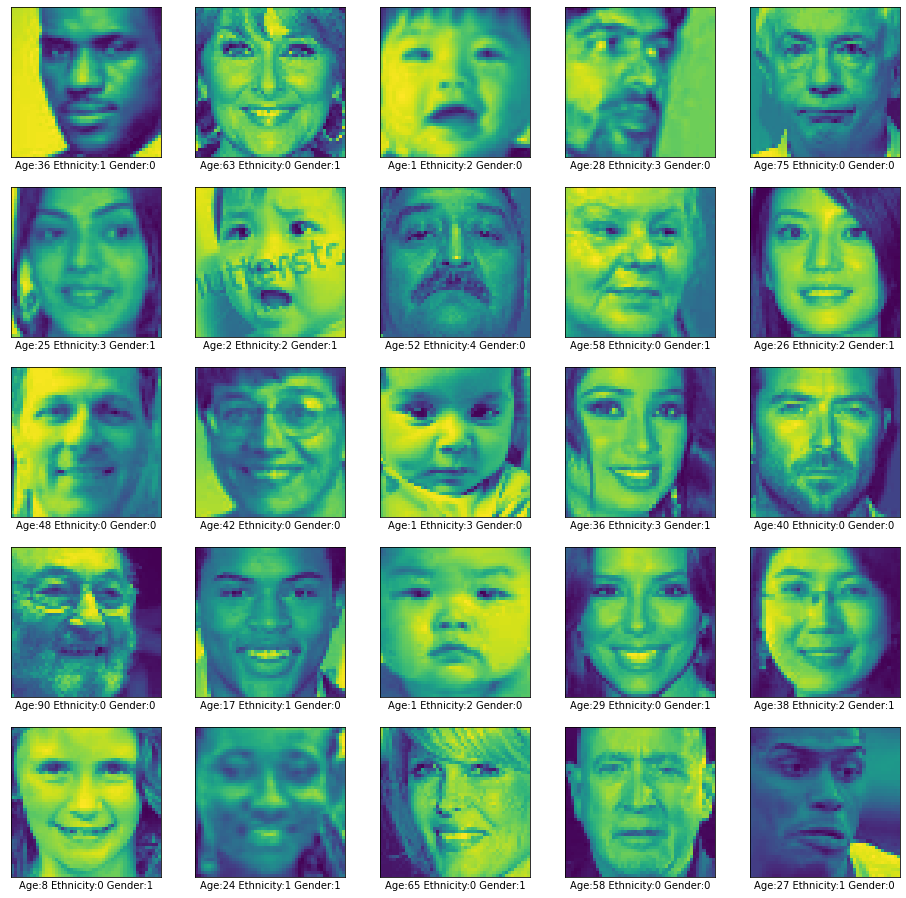

In [13]:
# print random images

index = np.random.randint(0,23704,25)

plt.figure(figsize=(16,16))

for i in range(len(index)):
    plt.subplot(5,5,(i%25)+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_reshaped[index[i]].reshape(IMG_SIZE,IMG_SIZE))
    plt.xlabel(
        "Age:"+str(df['age'].iloc[index[i]])+
        " Ethnicity:"+str(df['ethnicity'].iloc[index[i]])+
        " Gender:"+str(df['gender'].iloc[index[i]])
    )
    
plt.show()

## 4. Split and preprocess the data

In [14]:
y=np.zeros(shape=(23705,3))

for i in range(len(df)):
    y[i] = np.array([df.age[i], df.gender[i], df.ethnicity[i]])
    
y = y.astype(np.int32)

TARGETS = ['Age', 'Gender', 'Race']
AGE_IDX = 0
GENDER_IDX = 1
RACE_IDX = 2

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [16]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [17]:
print(X_train[1].shape)

(2304,)


In [18]:
len(X_train)

18964

[123. 141. 162. ...  33.  36.  37.]


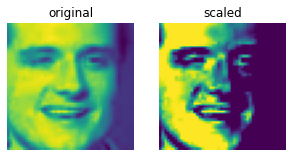

In [19]:
fig = plt.figure(figsize=(5,5))

plt.subplot(121)
original = np.clip(scaler.inverse_transform(X_train[0]),0,255)
print(original)
plt.imshow(original.reshape(IMG_SIZE,IMG_SIZE))
plt.title('original')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.clip(X_train[0],0,1).reshape(48,48))
plt.title('scaled')
plt.axis('off')

plt.show()

## 5. Modelling and Training

In [20]:
def test_predict(model, predict_index):
    f, ax = plt.subplots(5,5, figsize=(15,15))

    for i, data in enumerate(X_test[:25]):
        model_out = int(model.predict(data.reshape(1,-1))[0])

        if model_out == y_test[i,predict_index]:
            color = 'g'
        else:
            color = 'r'

        if(predict_index==GENDER_IDX):
            str_predicted = GENDER_CATEGORIES[model_out]
            str_true = GENDER_CATEGORIES[y_test[i,predict_index]]
        elif(predict_index==RACE_IDX):
            str_predicted = RACE_CATEGORIES[model_out]
            str_true = RACE_CATEGORIES[y_test[i,predict_index]]
        else:
            str_predicted = model_out
            str_true = model_out
            
        original = np.clip(scaler.inverse_transform(data),0,255)
        ax[i//5, i%5].imshow(original.reshape(IMG_SIZE,IMG_SIZE))
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title(f"Pred: {str_predicted} True: {str_true}", {'color' : color})    
    plt.show()

In [21]:
def fit_model(model, X_train, y_train, cv, parameters, predict_idx):
    fname = f'models/{predict_idx}-{type(model).__name__}.pkl'
    
    if os.path.isfile(fname):
        # Load from file
        with open(fname, 'rb') as file:
            clf = pickle.load(file)
    else:
        y_train = y_train[:,predict_idx]
        clf = sklearn.model_selection.GridSearchCV(model, parameters, verbose=1, cv=cv, n_jobs=-1)
        clf.fit(X_train, y_train)
        # Save to file
        with open(fname, 'wb') as file:
            pickle.dump(clf, file)
    
    print(f"{TARGETS[predict_idx]} {type(model).__name__}")
    print(f"Validation score: {clf.best_score_:.1%}")
    print(f"Best params: {clf.best_params_}\n")
    
    return clf

In [22]:
# clf = sklearn.tree.DecisionTreeClassifier(max_depth=10, splitter='random', random_state=0)
# clf.fit(X_train,y_train[:,2])

In [23]:
# print("train:   ", clf.score(X_train, y_train[:,2]))
# print("validate:", clf.score(X_val, y_val[:,2]))
# print("test:    ", clf.score(X_test, y_test[:,2]))

In [24]:
# test_predict(clf, RACE_IDX)

### 5a. Decision Trees

In [25]:
params = {'max_depth':[1, 5, 10, 20, 50, 100]}

start_time = time.time()

age_dt_model = fit_model(sklearn.tree.DecisionTreeClassifier(), X_train, y_train, 10, params, AGE_IDX)
gender_dt_model = fit_model(sklearn.tree.DecisionTreeClassifier(), X_train, y_train, 10, params, GENDER_IDX)
race_dt_model = fit_model(sklearn.tree.DecisionTreeClassifier(), X_train, y_train, 10, params, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age DecisionTreeClassifier
Validation score: 11.7%
Best params: {'max_depth': 5}

Gender DecisionTreeClassifier
Validation score: 73.0%
Best params: {'max_depth': 10}

Race DecisionTreeClassifier
Validation score: 53.3%
Best params: {'max_depth': 10}

Running Time: 0.021198034286499023


### 5b. Random Forests

In [26]:
param = {'max_depth':[1, 5, 10, 20, 50, 100]}

start_time = time.time()

age_rf_model = fit_model(sklearn.ensemble.RandomForestClassifier(), X_train, y_train, 10, param, AGE_IDX)
gender_rf_model = fit_model(sklearn.ensemble.RandomForestClassifier(), X_train, y_train, 10, param, GENDER_IDX)
race_rf_model = fit_model(sklearn.ensemble.RandomForestClassifier(), X_train, y_train, 10, param, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age RandomForestClassifier
Validation score: 14.2%
Best params: {'max_depth': 20}

Gender RandomForestClassifier
Validation score: 81.6%
Best params: {'max_depth': 50}

Race RandomForestClassifier
Validation score: 65.7%
Best params: {'max_depth': 20}

Running Time: 2.254681348800659


### 5c. Logistic Regression

In [27]:
param = {'C':[0.0001, 0.001, 0.01, 0.1, 1.0]}

start_time = time.time()

age_lr_model = fit_model(sklearn.linear_model.LogisticRegression(), X_train, y_train, 10, param, AGE_IDX)
gender_lr_model = fit_model(sklearn.linear_model.LogisticRegression(), X_train, y_train, 10, param, GENDER_IDX)
race_lr_model = fit_model(sklearn.linear_model.LogisticRegression(), X_train, y_train, 10, param, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age LogisticRegression
Validation score: 13.9%
Best params: {'C': 0.001}

Gender LogisticRegression
Validation score: 85.1%
Best params: {'C': 0.01}

Race LogisticRegression
Validation score: 72.3%
Best params: {'C': 0.01}

Running Time: 0.013390064239501953


### 5d. SVM

In [28]:
param = {'C':[0.1, 1, 10, 100, 1000], 'gamma':[0.001]}

start_time = time.time()

age_svm_model = fit_model(sklearn.svm.SVC(), X_train, y_train, 10, param, AGE_IDX)
gender_svm_model = fit_model(sklearn.svm.SVC(), X_train, y_train, 10, param, GENDER_IDX)
race_svm_model = fit_model(sklearn.svm.SVC(), X_train, y_train, 10, param, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age SVC
Validation score: 14.4%
Best params: {'C': 1, 'gamma': 0.001}

Gender SVC
Validation score: 86.7%
Best params: {'C': 10, 'gamma': 0.001}

Race SVC
Validation score: 74.3%
Best params: {'C': 10, 'gamma': 0.001}

Running Time: 2.975273609161377


### 5e. Neural Networks

In [29]:
def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy'):
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = inputs
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [30]:
tf.version.VERSION

'2.3.0'

In [33]:
gender_model = build_model(1, activation='sigmoid', loss='binary_crossentropy')

gender_history = gender_model.fit(
    X_train.reshape(-1,48,48),
    y_train[:,GENDER_IDX].reshape(-1),
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1
)

Epoch 1/10
238/238 [==============================] - 23s 99ms/step - loss: 0.4358 - accuracy: 0.7933 - val_loss: 0.3515 - val_accuracy: 0.8437
Epoch 2/10
238/238 [==============================] - 23s 95ms/step - loss: 0.3179 - accuracy: 0.8592 - val_loss: 0.3170 - val_accuracy: 0.8555
Epoch 3/10
238/238 [==============================] - 26s 108ms/step - loss: 0.2625 - accuracy: 0.8862 - val_loss: 0.2824 - val_accuracy: 0.8771
Epoch 4/10
238/238 [==============================] - 32s 133ms/step - loss: 0.2305 - accuracy: 0.9017 - val_loss: 0.2676 - val_accuracy: 0.8808
Epoch 5/10
238/238 [==============================] - 30s 124ms/step - loss: 0.2036 - accuracy: 0.9144 - val_loss: 0.3055 - val_accuracy: 0.8785
Epoch 6/10
238/238 [==============================] - 21s 89ms/step - loss: 0.1853 - accuracy: 0.9243 - val_loss: 0.2744 - val_accuracy: 0.8848
Epoch 7/10
238/238 [==============================] - 22s 94ms/step - loss: 0.1643 - accuracy: 0.9334 - val_loss: 0.2699 - val_accura

In [32]:
gender_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [85]:
gender_acc = gender_model.evaluate(X_test.reshape(-1,48,48), y_test[:,GENDER_IDX])[1]

149/149 [==============================] - 2s 15ms/step - loss: 0.3424 - accuracy: 0.8781


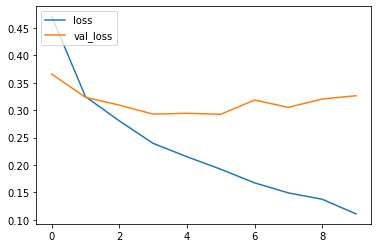

In [76]:
plt.plot(gender_history.history['loss'], label='loss')
plt.plot(gender_history.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

In [64]:
y_pred = gender_model.predict(X_test.reshape(-1,48,48)).flatten()

In [67]:
np.round(y_pred).astype(np.int32)

array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

In [94]:
age_model = build_model(117, activation='softmax', loss='sparse_categorical_crossentropy')

age_history = age_model.fit(
    X_train.reshape(-1,48,48),
    y_train[:,AGE_IDX].reshape(-1),
    validation_split=0.2,
    batch_size=64,
    epochs=7,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1
)

Epoch 1/7
238/238 [==============================] - 20s 83ms/step - loss: 0.5645 - accuracy: 0.7372 - val_loss: 0.3884 - val_accuracy: 0.8257
Epoch 2/7
238/238 [==============================] - 21s 88ms/step - loss: 0.3515 - accuracy: 0.8452 - val_loss: 0.3240 - val_accuracy: 0.8584
Epoch 3/7
238/238 [==============================] - 22s 91ms/step - loss: 0.3050 - accuracy: 0.8664 - val_loss: 0.3610 - val_accuracy: 0.8442
Epoch 4/7
238/238 [==============================] - 17s 73ms/step - loss: 0.2926 - accuracy: 0.8740 - val_loss: 0.3615 - val_accuracy: 0.8413
Epoch 5/7
238/238 [==============================] - 21s 88ms/step - loss: 0.2564 - accuracy: 0.8914 - val_loss: 0.3098 - val_accuracy: 0.8634
Epoch 6/7
238/238 [==============================] - 20s 84ms/step - loss: 0.2264 - accuracy: 0.9058 - val_loss: 0.2980 - val_accuracy: 0.8779
Epoch 7/7
238/238 [==============================] - 20s 84ms/step - loss: 0.2035 - accuracy: 0.9175 - val_loss: 0.2893 - val_accuracy: 0.8814

In [95]:
# Make predictions 
y_pred = age_model.predict(X_test.reshape(-1,48,48))

In [96]:
age_acc = age_model.evaluate(X_test.reshape(-1,48,48), y_test[:,AGE_IDX])[1]

149/149 [==============================] - 2s 15ms/step - loss: 18.6397 - accuracy: 0.0143


In [41]:
# output_indexes = np.array([i for i in range(0, 101)])
# apparent_predictions = np.sum(y_pred * output_indexes, axis = 1)

In [128]:
print(np.argmax(y_pred, axis=1)[4000:5000])

[1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0
 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0
 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1
 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1
 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0
 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0
 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0
 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1
 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0
 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1
 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 1 0
 1 1 0 0 1 0 0 0 1 1 0 1 

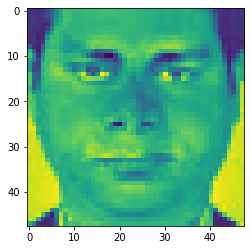

# Try it out - take a selfie! 😁

In [39]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def single_image_predict(models, image):
    '''
    models [age, gender, race]
    image 48x48 
    '''
    plt.imshow(image)
    image = rgb2gray(image)
    data = scaler.transform(image.reshape(1,-1))
    age_pred = int(models[0].predict(data.reshape(1,-1))[0])
#     gender_pred = GENDER_CATEGORIES[np.round(models[1].predict(data.reshape(-1,48,48)))]
    gender_pred = GENDER_CATEGORIES[int(models[1].predict(data.reshape(1,-1))[0])]
    race_pred = RACE_CATEGORIES[int(models[2].predict(data.reshape(1,-1))[0])]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Age: {age_pred}  Gender: {gender_pred}  Ethnicity: {race_pred}")
    plt.show()

In [42]:
from IPython.display import HTML

main_text = """

<input type="button" onclick="javascript:code_toggle()" value="Toggle code" style="display:inline"/>
<button id="snap">Snap Photo</button>
<div>
<video id="video" width="240" height="240" autoplay></video>
<canvas id="canvas" width="240" height="240"></canvas>
<canvas style="display:none" id="canvas2" width="48" height="48"></canvas>
</div>

<script>
// Grab elements, create settings, etc.
var video = document.getElementById('video');

// Get access to the camera!
if(navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
    // Not adding `{ audio: true }` since we only want video now
    navigator.mediaDevices.getUserMedia({ video: true }).then(function(stream) {
        //video.src = window.URL.createObjectURL(stream);
        //video.play();
        video.srcObject=stream;
        video.play();
    });
}

// Elements for taking the snapshot
var canvas = document.getElementById('canvas');
var context = canvas.getContext('2d');
var canvas2 = document.getElementById('canvas2');
var context2 = canvas2.getContext('2d');
var video = document.getElementById('video');

// Trigger photo take
document.getElementById("snap").addEventListener("click", function() {
    context.drawImage(video, 0, 0, 240, 240);
    context2.drawImage(video, 0, 0, 48, 48);
    var myCanvas2 = document.getElementById('canvas2');
    var image = myCanvas2.toDataURL("image/png");
    IPython.notebook.kernel.execute("print('testing')")
    IPython.notebook.kernel.execute("image = '" + image + "'")
});

code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);

</script>
"""
HTML(main_text)


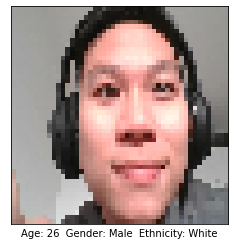

In [40]:
pil_im = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1])))
selfie = np.array(pil_im)[:,:,0:3]
single_image_predict([age_svm_model,gender_svm_model,race_svm_model], selfie)

In [ ]:
# img = cv2.imread('demo/', cv2.IMREAD_UNCHANGED)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# res = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)

In [ ]:
# single_image_predict([age_dt_model,gender_dt_model,race_dt_model], res)

## Just for fun!

In [74]:
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

def demo_image_predict(models):
    '''
    models [age, gender, race]
    image 48x48 
    '''
    f, ax = plt.subplots(1,5, figsize=(20,20))

    images = load_images_from_folder('demo')
    
    for i, image in enumerate(images):
        image = cv2.resize(image, dsize=(120, 120), interpolation=cv2.INTER_CUBIC)
        ax[i%5].imshow(image)
        image = cv2.resize(image, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
        image = rgb2gray(image)
        data = scaler.transform(image.reshape(1,-1))
        age_pred = int(models[0].predict(data.reshape(1,-1))[0])
        gender_pred = GENDER_CATEGORIES[np.round(models[1].predict(image.reshape(-1,48,48)).flatten()).astype(np.int32)[0]]
        race_pred = RACE_CATEGORIES[int(models[2].predict(data.reshape(1,-1))[0])]

        ax[i%5].grid(False)
        ax[i%5].axis('off')
        ax[i%5].set_title(f"Age: {age_pred}\n  Gender: {gender_pred}\n  Ethnicity: {race_pred}")
    plt.show()

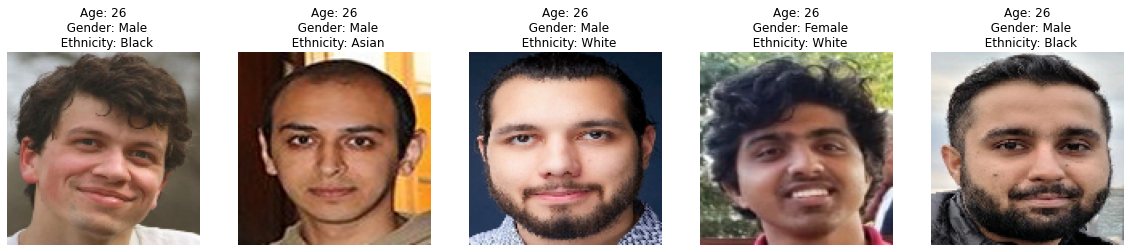

In [75]:
demo_image_predict([age_svm_model,gender_model,race_svm_model])